In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_groq import ChatGroq
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun

In [2]:
load_dotenv()
groq_model=ChatGroq(model="deepseek-r1-distill-llama-70b")

In [3]:
groq_model.invoke("hi")

AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.089165339, 'prompt_time': 0.000123329, 'queue_time': 1.070784892, 'total_time': 0.089288668}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'stop', 'logprobs': None}, id='run--f964ab4b-6d76-4cb4-bc5a-2dbf0ede8e6b-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})

In [4]:
search_tool=DuckDuckGoSearchRun()

In [23]:
search_tool.invoke("Hi")

c:\Users\91827\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


'Aug 30, 2024 · WIKO Hi GT Cube 显卡魔方 便携式高性能移动显卡坞 轻至630g 集成240W电源 显卡扩展坞即插即用 银色 华为hi gt cube 显卡魔方（华为显卡魔方）怎么 … Oct 1, 2009 · 美国各州州名以及缩写： 阿拉巴马州 Alabama AL 阿拉斯加州 Alaska AK 亚利桑那州 Arizona AZ 阿肯色州 Arkansas AR 加利福尼亚州 California … 三个打招呼的词，用法也有明显区别。 Hello： 多用于正规场合、大家不太熟、或俩人年龄、身份差异大时。 Hi： 比hello轻松；朋友、同级同事见面首选。 Hey：  … 知乎，中文互联网高质量的问答社区和创作者聚集的原创内容平台，于 2011 年 1 月正式上线，以「让人们更好的分享知识、经验和见解，找到自己的解答」为品牌使命 … 2025年华为笔记本如何选？六个系列一次性说清楚！ 178 赞同 34 评论 285 收藏'

In [6]:
repl=PythonREPL()

In [7]:
code = """
x = 5
y = x * 2
print(y)
"""

In [8]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [9]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\91827\AppData\Local\Temp\ipykernel_7700\290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\91827\AppData\Local\Temp\ipykernel_7700\290981387.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [10]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [11]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [12]:
"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [13]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [14]:
research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [15]:
chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [16]:
state={"message":["hi","hello"]}

In [17]:
state["message"][-1]

'hello'

In [18]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [19]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [20]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

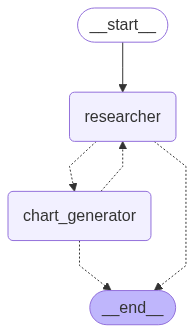

In [21]:
display(Image(app.get_graph().draw_mermaid_png()))

c:\Users\91827\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


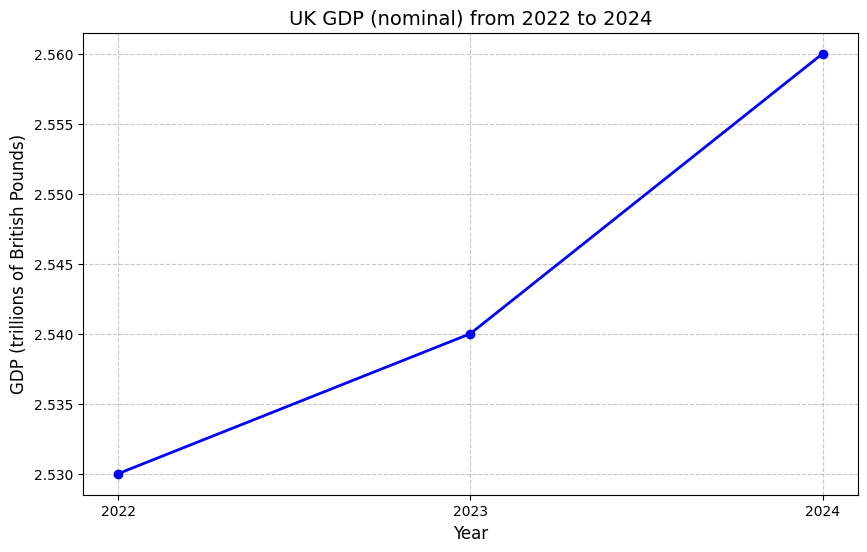

Task chart_generator with path ('__pregel_pull', 'chart_generator') wrote to unknown channel branch:to:__end__, ignoring it.


{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='d0d89c7e-d181-44c5-af91-651da18f44cc'),
  AIMessage(content="To find the UK's GDP data for the past three years, I'll start by using DuckDuckGo to search for the most recent and accurate figures. Once I have the data, I'll organize it and pass it along to create a line chart.\n\n", additional_kwargs={'tool_calls': [{'id': '34jzd30pg', 'function': {'arguments': '{"query":"UK GDP past 3 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 619, 'prompt_tokens': 281, 'total_tokens': 900, 'completion_time': 2.8049181279999997, 'prompt_time': 0.02582263, 'queue_time': 0.058094049999999994, 'total_time': 2.830740758}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_76307ac09b', 'finish_reason': 'tool_calls', 'logprobs'

In [22]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})